# Tyson Biegler
## Student ID: 012170282
## Advanced Data Analytics - D213 Task 2

# Part I: Reasearch Question
**A1:** Can neural networks be used to predict the sentiment of a review based on
previous reviews.

**A2:** The goal of this analysis is to build a model that can predit the sentiment of a customer review to determine if the review was favorable or not.

**A3:** I will be using Recurrent Neural Networks (RNN) for this assessment; specificially a Long Short-Term Memory (LSTM) model.

Import Libararies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from wordcloud import STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn import model_selection

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

pd.set_option('display.max_rows', None)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Read the text files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#files downloaded from (UCI Machine Learning Repository, n.d.)

df1 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/D213/amazon_cells_labelled.txt", sep='\t', header=None, names=['Review', 'sentiment'])


# IMDb file needed to be parsed differently to avoid panda's structure.
with open("/content/drive/My Drive/Colab Notebooks/D213/imdb_labelled.txt", "r", encoding="utf-8") as df2:
    raw_text = df2.read()


df3 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/D213/yelp_labelled.txt", sep='\t', header=None, names=['Review', 'sentiment'])

In [4]:
# Extract reviews and sentiments using regex becuase the imdb data wasnt splitting correctly. So this is my fix.
imdb_data = re.findall(r"(.*?)(?:\t([01])(?:\n|$))", raw_text)

In [5]:
df2 = pd.DataFrame(imdb_data, columns=['Review', 'sentiment'])
df2['sentiment'] = df2['sentiment'].astype(int)

In [6]:
# concatonating all the three dataframes.
reviews = pd.concat([df1, df2, df3], ignore_index=True)#(Sewell, n.d.)

In [7]:
reviews.head()

,Review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


# Part II: Data Preperation

**B1**. I began the exploratory data analysis (EDA) process by looking at the shape of the data, checking for sentiment counts, and ensuring there were no missing values.   


In [8]:
reviews.shape

(3000, 2)

In [9]:
#looking for counts of each sentiment
reviews.sentiment.value_counts()

,count
sentiment,
0,1500
1,1500


In [10]:
#checking for missing values
reviews.isna().sum()

,0
Review,0
sentiment,0


Before and after cleaning the data, I calculated the vocabulary size using keras `tokenizer`. Before cleaning, the vocabulary contained all uniqe tokens including the puncutuation and non-english characters that will be shown in the next section. The total vocabulary size before cleaning was 5271.

In [11]:
#Tokenize to get the vocabulary size across all reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews.Review)
print("Vocabulary size: ", len(tokenizer.word_index))

Vocabulary size:  5271


To check for non-english characters or emojies, I extracted all the unique values from the three concatonated dataframes using a for loop. The full list of unique characters can be found below. Later I removed all of the non-english characters as part of the cleaning process.

In [12]:
#Create list of characters to see if there are non english characters included in the dataframe
text = reviews['Review']
char_list = []
for i in text:
    for char in i:
        if char not in char_list:
            char_list.append(char)
print(char_list)

['S', 'o', ' ', 't', 'h', 'e', 'r', 'i', 's', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'U', 'I', 'b', 'c', 'v', '.', 'G', 'd', ',', 'E', 'x', 'j', 'T', '4', '5', 'M', 'A', 'J', 'O', 'R', 'P', 'B', 'L', '!', 'z', 'N', 'W', 'q', 'H', '+', 'V', '"', 'Y', 'D', 'F', 'k', "'", 'K', 'C', '/', '7', '3', '6', '8', '0', '2', '?', 'Z', '-', '1', ':', ')', '(', 'Q', '&', '$', '*', ';', 'X', '%', '9', '#', '[', ']', '\x96', 'é', '\x85', 'å', '\x97', 'ê']


To determine the maximum sequence length, I created a word_count column and identified the longest review based on tokens. I found that the IMDB data would combine several reviews into one line, resulting in a very long review. This was fixed by using special parcing to avoid pandas structure as it would not seperate by `"\t"` like the other two dataframes.

**B2**.  The goal of tokenization is to convert each review into a numeric value that can be traced back to a unique word in the dataset.


To ensure that the data was clean and standardized before tokenization, I applied the following steps:

1.   Converted to lowercase
2.   Removed punctuation
3.   Removed stropwords
4.   lemmatization



In [13]:
#convert to lowercase
reviews.Review = reviews.Review.str.lower()

#remove punctuation
reviews.Review = reviews.Review.apply(lambda x: re.sub(r'[^a-z]', ' ', x))
reviews.Review = reviews.Review.apply(lambda x: re.sub(r'\s+[a-z]\s+', ' ', x))

#remove stopwords
reviews.Review = reviews.Review.apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

#lemmatization
def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
lemmatizer= WordNetLemmatizer()
reviews.Review = \
    reviews.Review.apply(lambda x: ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(x)]))


I added a column to store the word counts, and removed reviews in which the word count was less than 3 words as they will not likely contribute anything meaningful to the model.

In [14]:
#Create a column for word count
reviews['Word_Count'] = reviews['Review'].apply(lambda x: len(str(x).split()))

In [15]:
#Remove entires with 3 words or less to remove noise
reviews = reviews[reviews['Word_Count'] > 3]

Now that the data is ready for tokenization, I run the following code to generate a vocabulary that essentially maps each word to a unique number. The vocabulary before clenaning was 5271 and is now 3995 after cleaning.

In [16]:
#Tokenizing after cleaning
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews.Review)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size after text cleaning: ", vocab_size)

Vocab size after text cleaning:  3998


In [17]:
#The longest review
print(reviews.loc[reviews['Word_Count'].idxmax(), 'Review'])


masterful piece film make many theme simmer occasionally boil wart study poet bohemian self indulgent wartime year span aerial bombardment london outward tranquillity welsh coastal retreat borderline friendship lust love dedication art experience versus practical concern jealousy rivalry cowardice egotism versus heroism self sacrifice


**B3**. Because each review has different lengths, it is important to pad each sequence to make them all the same length.

In [18]:
#Set max length based on word count of longest review
max_length = max(reviews['Word_Count'])
print("Number of words in longest review: ", max_length)

Number of words in longest review:  44


In [19]:
#The longest review
index_of_longest_sentence = reviews['Word_Count'].idxmax()
longest_sentence = reviews.loc[index_of_longest_sentence, 'Review']
print(longest_sentence)

masterful piece film make many theme simmer occasionally boil wart study poet bohemian self indulgent wartime year span aerial bombardment london outward tranquillity welsh coastal retreat borderline friendship lust love dedication art experience versus practical concern jealousy rivalry cowardice egotism versus heroism self sacrifice


I am using the longest reivew to be the 'padding length' for the rest of the reviews. The padding also occurs before the training split but after tokenization.

In [20]:
#Tokenize to encode to numeric values
tokenizer= Tokenizer(num_words= vocab_size)
tokenizer.fit_on_texts(reviews.Review)
encoded_reviews= tokenizer.texts_to_sequences(reviews.Review)
padded_reviews= pad_sequences(encoded_reviews, maxlen= max_length)

The following is the padded sequence of the longest review that was displayed earlier.

In [21]:
#taking a look at the padded review of the longest review
padded_reviews[1620]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,   85, 1742, 1743,  845, 3618],
      dtype=int32)

**B4**. In this assessment the data is represented as binary values of `0` for negative sentiment and `1` for positive sentiment. Becuase I am classifying into two categories, the the activation function is `sigmoid` and there is `1` output.  

`model.add(Dense(1, activation= 'sigmoid')) ` (Sewell, n.d.)


In [22]:
#Sentiment categories and their count
reviews.sentiment.value_counts()

,count
sentiment,
0,1039
1,1021


**B5**. I split the data into the industry standard, 80/20 split into training and test.

In [23]:
#Splitting 80/20
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    padded_reviews,
    reviews['sentiment'],
    test_size=0.20,
    random_state=386,
    stratify=reviews['sentiment']
)

In [24]:
train_shape = X_train.shape[0]
print("Input shape: ", train_shape)

Input shape:  1648


**B6**. The following files will be included in the submission files:

*   `reviews_training.csv`
*  ` reviews_test.csv`
*   `labels_training.csv`
*   `labels_test.csv`




Prepping the data for the model

In [25]:
#exporting the files for B6
pd.DataFrame(X_train).to_csv('/content/drive/My Drive/Colab Notebooks/D213/reviews_training.csv')
pd.DataFrame(X_test).to_csv('/content/drive/My Drive/Colab Notebooks/D213/reviews_test.csv')

pd.DataFrame(y_train).to_csv('/content/drive/My Drive/Colab Notebooks/D213/labels_training.csv')
pd.DataFrame(y_test).to_csv('/content/drive/My Drive/Colab Notebooks/D213/labels_test.csv')

#Part III: Network Architecture

**C1.** The following is the `model.summary()` of the function from tensorflow.


In [26]:
#(Sewell, n.d.)
model= Sequential()
model.add(Input(shape= (train_shape, )))
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128, dropout= 0.5, recurrent_dropout= 0.5, activation= 'tanh'))
model.add(Dense(1, activation= 'sigmoid'))
model.compile(loss= 'binary_crossentropy', optimizer= Adam(learning_rate= 0.0001), metrics= ['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1648, 100)      │       399,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 517,177 (1.97 MB)

 Trainable params: 517,177 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

None


**C2.** This is a seqential model with three layers. The first layer is an `embedding` layer, which has 399,800 pparameters, which are learned during training. The second layers is an `LSTM` layer to help the model process sentences. The third layer is a `dense` layer with 1 unit, which outputs a binary prediction of either `0` or `1` for positive or negative.

**C3**. The activation functions were `tanh` for the LSTM layer, and `sigmoid` in the dense layer to allow for the binary output of 0 or 1. The loss function is `binary_crossentropy` because this task is a binary classificaiton of 1 and 0 as mentioned before. This model used the `Adam` optimizer with a 0.0001 learning rate for smooth training (GeeksforGeeks, 2025). The stopping criteria was set to a patience of 3 epochs since the total epochs in the `model.fit()` was set to 15. Lastly, the evaluation metric was set to `accuracy`.

Part IV: Model Evaluation


**D1.** As noted in the previous section, the pattience is set to 3 becuase the total epochs to be ran is set to 15. The following code demonstrates that the early_stopping was never activated since the model continously improved through the 15 epochs. However, the validation accuracy did appear to plateau around 8 epochs.

**D2.** The model appeared to perform well with the training and validation accuracy closely alligned. I orginally ran the model with 20 epochs and a patience of 5 but the validation accuracy platteued around 7 epochs, suggesting overfitting. Making these changes impoved accuracy and vaidation accuracy.

In [27]:
early_stopping = EarlyStopping(patience= 3)

In [28]:
history = model.fit(X_train, y_train, epochs= 20, validation_data= (X_test, y_test), callbacks= [early_stopping]) # Setting epochs to 20 (Sewell, n.d.)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.5018 - loss: 0.6938 - val_accuracy: 0.5146 - val_loss: 0.6923
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.5267 - loss: 0.6922 - val_accuracy: 0.5243 - val_loss: 0.6914
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.5914 - loss: 0.6892 - val_accuracy: 0.5267 - val_loss: 0.6902
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5885 - loss: 0.6883 - val_accuracy: 0.5777 - val_loss: 0.6886
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.6236 - loss: 0.6854 - val_accuracy: 0.5971 - val_loss: 0.6859
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.6720 - loss: 0.6802 - val_accuracy: 0.6942 - val_loss: 0.6816
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.7468 - loss: 0.6713 - val_accuracy: 0.7063 - val_loss: 0.6736
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.7658 - loss: 0.6538 - val_accurac

**D3.** Plotting model accuracy and loss

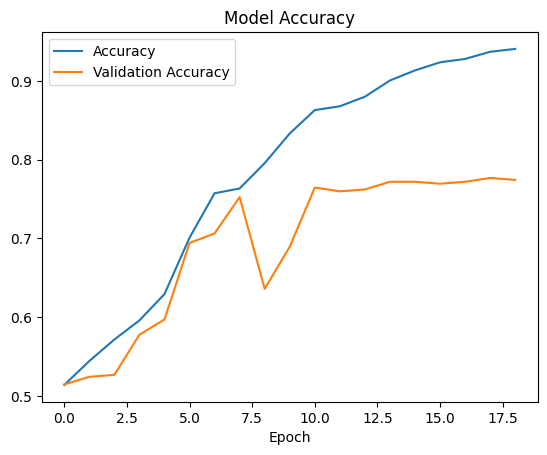

In [29]:
#Model Accuracy
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

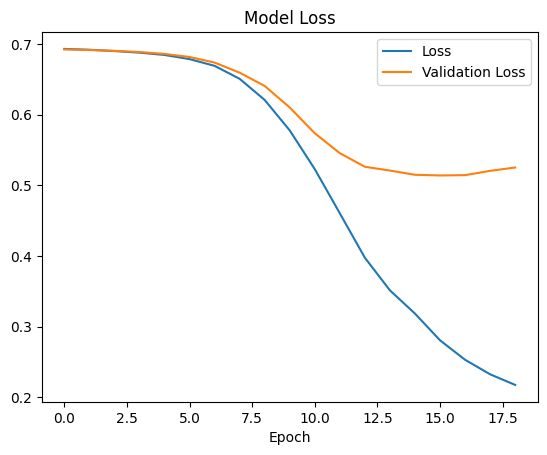

In [30]:
#Model Loss
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Evaluating the model using the test set

**D4.** The models accuracy is 76.06%

In [31]:
model.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7703 - loss: 0.5475


[0.5250909924507141, 0.7742718458175659]

In [32]:
#saving the model
model.save('sentiment_analysis_model.keras')

In the following lines of code, I test two seperate sentences expecting to see a sentiment prediction of 1 or 0.

In [33]:
def predict_sentiment(text):
    tw= tokenizer.texts_to_sequences([text])
    tw= pad_sequences(tw)
    prediction= int(model.predict(tw).round().item())
    print("Predicted label: ", prediction)

In [36]:
#Expecting a prediction of 1
test_sentence1 = "I love this camera"
predict_sentiment(test_sentence1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted label:  1


In [37]:
#Expecting a prediction of 0
test_sentence2 = "I hate this camera."
predict_sentiment(test_sentence2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted label:  0


#Part VI: Reporting

**H1.** The PDF file of this report will be included in the submission files.

**I1.** Web Sources
*   UCI Machine Learning Repository. (n.d.). Sentiment labelled sentences [Data set]. University of California, Irvine. https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences

*   GeeksforGeeks. (2025, March 10). Adam optimizer in TensorFlow. https://www.geeksforgeeks.org/adam-optimizer-in-tensorflow/#

**J1.** This code was adapted from the course webinar videos listed below.

*   Sewell, W. (n.d.). D213 Webinar 3: Transition [Webinar]. Western Governors University. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=ea04fe77-3e3a-4293-8e9f-af7a00f22a8c
*   Sewell, W. (n.d.). D213 SA Webinar 4 [Webinar]. Western Governors University. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=c2642337-7947-4e7c-aa8d-af7b01456876
*   Sewell, W. (n.d.). Webinar 5 SA [Webinar]. Western Governors University. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=8502edc2-27b3-46ed-ab9c-af89012040ed
*   Sewell, W. (n.d.). D213 Webinar 6 SA [Webinar]. Western Governors University. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=c3890312-a194-4f3a-b579-af8901300903











